# Interactive flow curation curve

This notebook creates an interactive flow duration curve. 

This notebook creates an interactive hydrograph that is used to return Earth observation images.
Daily streamflow information and stream gauge coordinates are retrieved directly from the Bureau of Meteorology (BoM) Hydrologic Reference Stations (HRS) website, http://www.bom.gov.au/water/hrs/. The date of streamflow measurement and date of avaliable satellite imagery are matched, for the location of the gauge. 

A flow duration cuve plot is created that enables the user to click on any percentage exceedance value and return the closest satellite image, for a small area surrounding the location stream gauge. Further, a larger image is then returned and there is an option to save imagery as a netcdf file.

"###" indicates fields that require user modification

In [6]:
#Import libraries
%pylab notebook

import datacube
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

import pandas as pd
import xarray as xr
import numpy as np
import csv
import os
import datetime

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

import rasterio
import urllib
from pyproj import Proj, transform
from dateutil import tz
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


## Retrieve the stream gauge data and coordinates from the BoM website
The URL for the data is set using the gauge_of_interest

In [7]:
#Specify stream gauge of interest.

###Enter the ID code for the gauge of interest. ID code can be viewed on http://www.bom.gov.au/water/hrs/
###e.g. for 'Diamantina River at Birdsville' the ID code is 'A0020101'

gauge_of_interest= 'A0020101'

In [8]:
#Url is used to retrieve daily streamflow data for the gauge_of_interest    
url = 'http://www.bom.gov.au/water/hrs/content/data/'+gauge_of_interest+'/'+gauge_of_interest+'_daily_ts.csv'
gaugedata = pd.read_csv(url, comment='#')
print (gaugedata)

             Date  Flow (ML) Bureau QCode
0      1966-10-19     0.0000            A
1      1966-10-20     0.0000            A
2      1966-10-21     0.0000            A
3      1966-10-22     0.0000            A
4      1966-10-23     0.0000            A
5      1966-10-24     0.0000            A
6      1966-10-25     0.0000            A
7      1966-10-26     0.0000            A
8      1966-10-27     0.0000            A
9      1966-10-28     0.0000            A
10     1966-10-29     0.0000            A
11     1966-10-30     0.0000            A
12     1966-10-31     0.0000            A
13     1966-11-01     0.0000            A
14     1966-11-02     0.0000            A
15     1966-11-03     0.0000            A
16     1966-11-04     0.0000            A
17     1966-11-05     0.0000            A
18     1966-11-06     0.0000            A
19     1966-11-07     0.0000            A
20     1966-11-08     0.0000            A
21     1966-11-09     0.0000            A
22     1966-11-10     0.0000      

In [9]:
#Url is used to retrieve stream gauge location coordinates. Coordinates are reprojected to Australian Albers    

#Search url to find coordinates 
coord_txt = urllib.request.urlopen(url).read()
coord_txt = str(coord_txt)
sg_lon = coord_txt.split('"Location:", ')[1].split(',"degrees E",')[0]
sg_lon=float(sg_lon)
sg_lat = coord_txt.split(',"degrees E", ')[1].split(',"degrees S"')[0]
sg_lat= "-"+sg_lat
sg_lat=float(sg_lat)

#Reproject
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
sg_x,sg_y = transform(inProj,outProj,sg_lon,sg_lat)

print ("Geographic: " + str(sg_lon)+', '+ str(sg_lat))
print ("Australian Albers: "+ str(sg_x)+', '+str(sg_y))

Geographic: 139.3667, -25.9088
Australian Albers: 728893.3995514876, -2825460.0787998526


## Complete Datacube query

In [10]:
#Spatiotemporal range and wavelengths/band of interest are defined

#Define temporal range
start_of_epoch = '1987-01-01'
end_of_epoch =  '2014-12-31'

#Define wavelengths/bands of interest
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Define sensors of interest
sensors = ['ls8',
    'ls7',
    'ls5' ] 

#Create bounding box around the location of the stream gauge
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [11]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

## Complete Datacube extraction
The extracted data is first filtered using the criteria in "mask_components". The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_threshold" are discarded

In [12]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_threshold = 0.90  ###User requirement: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_threshold
        
    #Discard data that does not meet the cloud_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [13]:
# Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 302, x: 422, y: 471)
 Coordinates:
   * time     (time) datetime64[ns] 1987-05-22T00:01:19.500000 ...
   * y        (y) float64 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 ...
   * x        (x) float64 7.236e+05 7.237e+05 7.237e+05 7.237e+05 7.237e+05 ...
 Data variables:
     green    (time, y, x) float64 1.571e+03 1.571e+03 1.632e+03 1.571e+03 ...
     red      (time, y, x) float64 2.364e+03 2.417e+03 2.47e+03 2.47e+03 ...
     nir      (time, y, x) float64 2.992e+03 2.992e+03 3.12e+03 3.056e+03 ...
     swir1    (time, y, x) float64 3.842e+03 3.976e+03 4.11e+03 4.066e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 60, x: 422, y: 471)
 Coordinates:
   * time     (time) datetime64[ns] 1999-07-18T00:30:07.500000 ...
   * y        (y) float64 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 ...
   * x        (x) flo

In [14]:
#Concatenate (join) the data from the different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [15]:
# Check that the concatenation worked
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 394, x: 422, y: 471)
Coordinates:
  * y        (y) float64 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 -2.82e+06 ...
  * x        (x) float64 7.236e+05 7.237e+05 7.237e+05 7.237e+05 7.237e+05 ...
  * time     (time) datetime64[ns] 1987-05-22T00:01:19.500000 ...
Data variables:
    green    (time, y, x) float64 1.571e+03 1.571e+03 1.632e+03 1.571e+03 ...
    red      (time, y, x) float64 2.364e+03 2.417e+03 2.47e+03 2.47e+03 ...
    nir      (time, y, x) float64 2.992e+03 2.992e+03 3.12e+03 3.056e+03 ...
    swir1    (time, y, x) float64 3.842e+03 3.976e+03 4.11e+03 4.066e+03 ...
    product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 723625.00|\n| 0.00,-25.00,-2819575.00|\n| 0.00, ...

## Process stream gauge information
Calculate the percentiles of stream flow, and sort the dataframe according to date

In [16]:
#Calculate "percentage exceedance" (perexc) for stream flow values

all_data = gaugedata #Import streamflow data from the gauge of interest
all_data= all_data.rename(columns={'Flow (ML)':'flow', 'Date':'date'})  #Rename flow and date columns
all_data = all_data.sort_values('flow', ascending=[False]) #Sort data by flow value
all_data['ranks'] = np.arange(len(all_data)) + 1 #Create rank column and values
all_data['perexc'] = 100*(all_data['ranks'])/(len(all_data)+1) #Calculate probability of each rank
all_data= all_data.sort_values(['date']) #Sort data by date
all_data=all_data.drop(all_data.columns[[2]], axis=1) #Remove "Bureau QCode" column
all_data['date']=pd.to_datetime(all_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format
all_data.date = all_data.date.map(lambda t: t.strftime('%Y-%m-%d')) #Change datetime format

## Return just the time and sensor product information from the Datacube extraction

In [17]:
product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

## Match the date of stream flow data to the date where satellite information exists

In [18]:
subset_data = pd.merge(all_data, product_time, left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

In [19]:
subset_data['date']=pd.to_datetime(subset_data['date'], format='%Y/%m/%d %H:%M:%S') # back to datetime format

# Create interactive flow duration curve

In [20]:
#Prepare flow and percentage exceedance variables for plotting on FDC

#Preapre all data
sorted_a_flow=sorted(all_data.flow, reverse=True)
sorted_a_pe=sorted(all_data.perexc)

#Prepare the matched subset data
sorted_s_flow=sorted(subset_data.flow, reverse=True)
sorted_s_pe=sorted(subset_data.perexc)

<IPython.core.display.Javascript object>


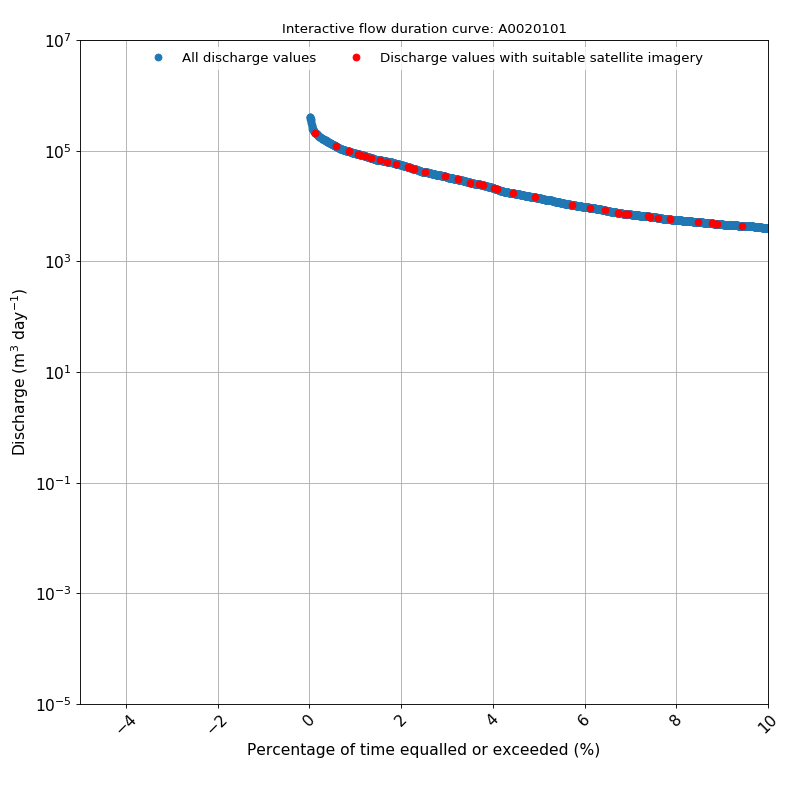

In [25]:
#Ceate interactive flow duration curve

#create widget that enables interaction with plot
w = widgets.HTML("Click on a point on the curve to display the satellite image")
def callback(event):
    global discharge_int, perexc_int, devent
    devent = event
    discharge_int = event.ydata
    perexc_int = event.xdata
    discharge_int = discharge_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)


#Set up plot
fig = plt.figure(figsize=(10,10)) #Edit size of plot ###User should format as required
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive flow duration curve: '+gauge_of_interest) #Plot title ###User should format if required
display(w) #Plot setup
pyplot.yscale('log') #set up Y axis as a log scale
plt.subplots_adjust(left=0.10, right=0.96, top=0.95, bottom=0.12) #Set border dimensions  ###User should format if required
fig.patch.set_facecolor('white')  #Make border white ###User should format if required
fig.patch.set_alpha(0.99)  #Make border white ###User should format if required
plt.grid(True) #Add gridlines to the figure

#create plot of percent exceedance
plt.plot(sorted_a_pe,sorted_a_flow,'o',label= 'All discharge values')  #plot all discharge values ###User should format series if required
plt.plot(sorted_s_pe,sorted_s_flow,'ro',label='Discharge values with suitable satellite imagery') #plot matched discharge values ###User should format series if required


#axis and legend details
plt.axis([-5, 10, 0.00001, 10000000]) ### User requirement: set axis values for 
plt.xticks(rotation=45,size=14) #Rotate and format size of date labels ###User should format if required
plt.yticks(size=14) #Rotate and format size of date labels ###User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)', size=14) #Set Y label
plt.xlabel('Percentage of time equalled or exceeded (%)', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=2, loc=9, fontsize=12) ##Set legend location on plot #Make border white ###User should format if required

plt.show() #Show plot

In [22]:
# save figure
###User requirement: enter directory to save figure
%cd /g/data/r78/ext547/Output/FDC/
plt.savefig('FDC_'+gauge_of_interest+'_withsat.jpg')  ###User should format if required

/g/data1/r78/ext547/Output/FDC


In [26]:
#Show values for click on interactive graph

print ('Clicked discharge value: ' + str(discharge_int) + ' m3')
print ('Clicked percentage exceedance value: ' + str(perexc_int) +' %')

Clicked discharge value: 206968.065401 m3
Clicked percentage exceedance value: 0.0761626487555 %


In [27]:
# Define the closest real value from the clicked point on the interactive graph. For example, find the exact date of the 
#satellite pass or the exact discharge or flow exceedance value and format for imagery titles.

#Date
time_slice=subset_data.iloc[(subset_data.perexc - perexc_int).abs().argsort()[0:1]].date
time_slice= (list(time_slice)[0])
time_slice= str(time_slice) 
time_slice=datetime.datetime.strptime(time_slice,'%Y-%m-%d %H:%M:%S')
time_slice_actual=time_slice
time_slice_t1=time_slice_actual + datetime.timedelta(days=-2)
time_slice_t2=time_slice_actual + datetime.timedelta(days=2)

#Discharge 
discharge_title=subset_data.iloc[(subset_data.perexc - perexc_int).abs().argsort()[:1]].flow
discharge_title2= float(discharge_title)
discharge_title2=str("{0:.2f}".format(discharge_title2))

#Percentage exceedance
perexc_title=subset_data.iloc[(subset_data.perexc - perexc_int).abs().argsort()[:1]].perexc
perexc_title2= float(perexc_title)
perexc_title2=str("{0:.2f}".format(perexc_title2))

#Satellite
satellite_type=subset_data.iloc[(subset_data.perexc - perexc_int).abs().argsort()[:1]]
satellite_type=satellite_type['product']
satellite_type= (list(satellite_type)[0])
satellite_type= str(satellite_type)+'_nbar_albers'


print ('Time 1:' +str(time_slice_t1))
print ('Actual observation date: ' +str(time_slice_actual))
print ('Time 2: ' +str(time_slice_t2))
print ('Discharge: ' +str(discharge_title2) +' m3')
print ('Perexc_int: ' +str(perexc_int) +'%')
print ('Percent exceedance: '+ str(perexc_title2) + '%')
print ('Product: '+ str(satellite_type)) 

Time 1:1991-02-24 00:00:00
Actual observation date: 1991-02-26 00:00:00
Time 2: 1991-02-28 00:00:00
Discharge: 210856.00 m3
Perexc_int: 0.0761626487555%
Percent exceedance: 0.12%
Product: ls5_nbar_albers


<IPython.core.display.Javascript object>


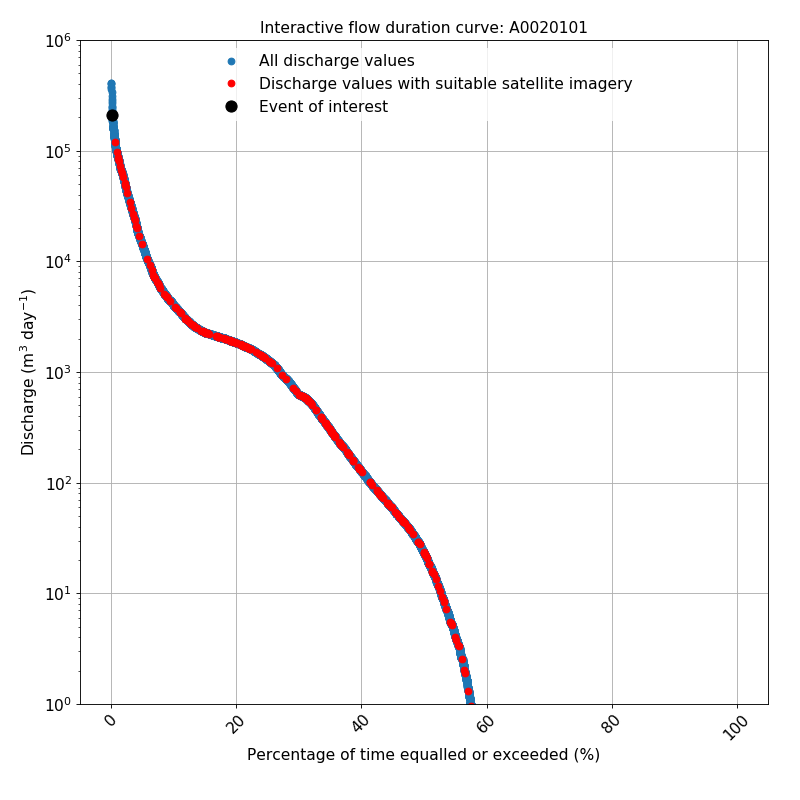

In [28]:
#create flow duration curve showing date of interest

#Setup plot
fig = plt.figure(figsize=(10,10)) #Edit size of plot ###User should format as required
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive flow duration curve: '+gauge_of_interest, fontsize=14) #Plot title ###User should format if required
display(w) #Plot setup
pyplot.yscale('log') #set up Y axis as a log scale
plt.subplots_adjust(left=0.10, right=0.96, top=0.95, bottom=0.12) #Set border dimensions  ###User should format if required
fig.patch.set_facecolor('white')  #Make border white ###User should format if required
fig.patch.set_alpha(0.99)  #Make border white ###User should format if required
plt.grid(True) #Add gridlines to the figure

#create plot of percent exceedance
plt.plot(sorted_a_pe,sorted_a_flow,'o',label= 'All discharge values')  #plot all discharge values ###User should format series if required
plt.plot(sorted_s_pe,sorted_s_flow,'ro',label='Discharge values with suitable satellite imagery') #plot matched discharge values ###User should format series if required
plt.plot(perexc_title2,discharge_title2, 'ko', label='Event of interest',ms=10) #plot event of interest ###User should format series if required

#axis and legend details
plt.axis([-5, 105, 1, 1000000]) ### User requirement: set axis values for 
plt.xticks(rotation=45,size=14) #Rotate and format size of date labels ###User should format if required
plt.yticks(size=14) #Rotate and format size of date labels ###User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)', size=14) #Set Y label
plt.xlabel('Percentage of time equalled or exceeded (%)', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=1, loc=9, fontsize=14) ##Set legend location on plot #Make border white ###User should format if required

plt.show() #Show plot

In [ ]:
#Save figure
###User requirement: enter directory to save figure
%cd /g/data/r78/ext547/Output/FDC/
plt.savefig('FDC_'+gauge_of_interest+'_PE'+str(perexc_title2)+'.jpg') ### User should format if required

# Creation of image showing a small area directly around stream gauge

In [29]:
#Prepare imagery
rgb = nbar_clean.sel(time =time_slice_actual, method = 'nearest').to_array(dim='color').sel(color=['swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


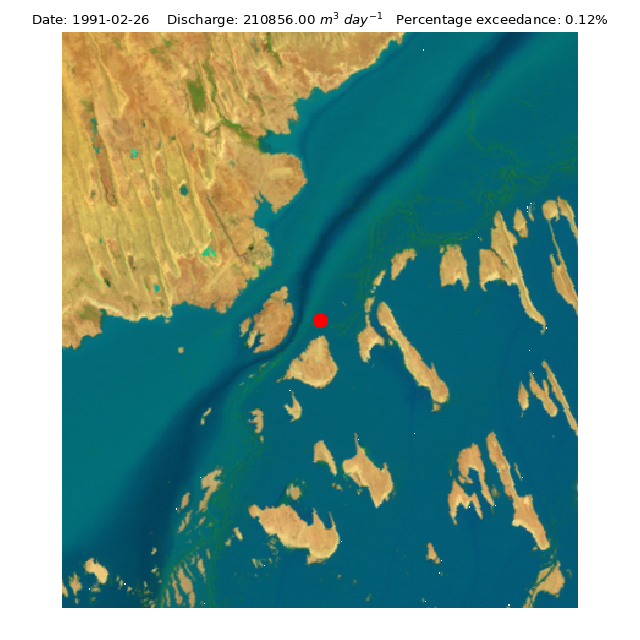

In [30]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ###User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ###User should format if required
fig.patch.set_facecolor('white') #Make border white ###User should format if required
fig.patch.set_alpha(0.99)#Make border white ###User should format if required
plt.axis('off')#remove axis ###User should delete code if required

#Edit plot title ###User should format as required
plt.title('Date: '+str(time_slice_actual)[0:-9]  + 
          '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
          '   Percentage exceedance: '+ str(perexc_title2) + '%', size=12) 

#Add marker to show location of stream gauge 
plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=150)
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                  scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [ ]:
#save figure
###User requirement: enter directory to save figure
%cd /g/data/r78/ext547/Output/FDC/ 
plt.savefig('FDC_'+gauge_of_interest+'_PE'+ str(perexc_title2) + '_D'+str(discharge_title2) +
            '_'+ str(time_slice_actual)[0:-9] +'_small'+ '.jpg') ###User should format if required

## Creation of image showing a large area around the stream gauge

In [31]:
#Create Datacube query for event of interest

#Define date for event of interest
start_of_epoch = time_slice_t1.strftime("%Y %m, %d") 
end_of_epoch = time_slice_t2.strftime("%Y %m, %d")

#Define area of interest 
###User requirement: change area of interest to suit gauge location in relation to satellite pass
lat_max = sg_lat+ 0.6 #up
lat_min = sg_lat- 0.6 #down
lon_max = sg_lon+ 0.8 #right
lon_min = sg_lon- 0.4 #left

#Create query 
query2 = {
    'time': (start_of_epoch, end_of_epoch)
        }
query2['x'] = (lon_min, lon_max)
query2['y'] = (lat_max, lat_min)
query2['crs'] = 'EPSG:4326'
print (query2)

{'time': ('1991 02, 24', '1991 02, 28'), 'x': (138.9667, 140.16670000000002), 'y': (-25.308799999999998, -26.5088), 'crs': 'EPSG:4326'}


In [32]:
#Load image data for event of interest   
image_of_interest = dc.load(product= satellite_type, group_by='solar_day',
                            measurements = bands_of_interest,  **query2)

In [33]:
#Prepare imagery
rgb2 = image_of_interest.to_array(dim='color').sel(color=['swir1',
                                                          'nir', 'green']).squeeze().transpose('y', 'x', 'color')
fake_saturation = 6000
clipped_visible = rgb2.where(rgb2<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [34]:
#Create large area image

fig = plt.figure(figsize =(21,21))  #Edit size of plot ###User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ###User should format if required
fig.patch.set_facecolor('white') #Make border white ###User should format if required
fig.patch.set_alpha(0.99) #Make border white ###User should format if required
plt.axis('off') #remove axis ###User should delete code if required

#Edit plot title ###User should format as required
plt.title('Gauge: '+gauge_of_interest +'    Date: '+str(time_slice_actual)[0:-9]  + 
          '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
          '   Percentage exceedance: '+ str(perexc_title2) + '%', size=22)

#Add marker to show location of stream gauge 
plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=500)
plt.imshow(scaled, interpolation = 'nearest', 
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(),
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot


<IPython.core.display.Javascript object>

In [35]:
#save figure
### User requirement: enter directory to save figure
%cd /g/data/r78/ext547/Output/FDC/ 
plt.savefig('FDC_'+gauge_of_interest+'_PE'+ str(perexc_title2) + '_D'+str(discharge_title2)+
            '_'+ str(time_slice_actual)[0:-9] +'_large'+ '.jpg') ### User should format if required

/g/data1/r78/ext547/Output/FDC


In [36]:
stop here

SyntaxError: invalid syntax (<ipython-input-36-f9ef205a8f26>, line 1)

# If required, save as image in netcdf format

In [37]:
#Retrieve the original nbar dataset attributes (crs)

attrs = image_of_interest #set up variable attributes to hold the attributes

#get the band information
bands = attrs.data_vars.keys()
print (bands)
for i in bands:
    #drop band data, retaining just the attributes
    attrs =attrs.drop(i)
    
#set up new variable called ndvi_var, and assign attributes to it in a dictionary
image_var = {'scaled':''}
image_output = attrs.assign(**image_var)
image_output['scaled'] = scaled
print (image_output)
image_output2 = image_output.scaled.to_dataset(dim='color')

#print image output
image_output2.attrs['crs'] = image_output.crs

KeysView(Data variables:
    green    (time, y, x) int16 1325 1250 1212 1212 1250 1362 1549 1661 1661 ...
    red      (time, y, x) int16 1405 1305 1238 1238 1405 1838 2235 2532 2466 ...
    nir      (time, y, x) int16 3816 3900 3942 3984 4026 3942 3984 3816 3858 ...
    swir1    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...)
<xarray.Dataset>
Dimensions:  (color: 3, x: 5063, y: 5654)
Coordinates:
    time     datetime64[ns] 1991-02-25T23:57:58.500000
  * y        (y) float64 -2.756e+06 -2.756e+06 -2.756e+06 -2.756e+06 ...
  * x        (x) float64 6.857e+05 6.857e+05 6.857e+05 6.858e+05 6.858e+05 ...
  * color    (color) <U5 'swir1' 'nir' 'green'
Data variables:
    scaled   (y, x, color) float64 -0.1665 0.636 0.2208 -0.1665 0.65 0.2083 ...
Attributes:
    crs:      EPSG:3577


In [38]:

#Create netcdf
outfile = '/g/data/r78/ext547/Output/netcdf/'+ str(time_slice_actual)[0:-9] +'.nc' ###User requirement: enter directory and file name
write_dataset_to_netcdf(image_output2,  variable_params={'scaled': {'zlib':True}}, filename=outfile) #Create file

print ('wrote: '+outfile+' to netcdf')

wrote: /g/data/r78/ext547/Output/netcdf/1991-02-26.nc to netcdf
